In [52]:
import os, sys

import sgpp
import dproc
import sgutil
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(sys.version)

from sklearn.pipeline import make_pipeline

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]


In [4]:
for i in ['data', 'result', 'model']:
    if not os.path.exists(i):
        os.mkdir(i)

In [7]:
if not os.path.exists('data/train.csv'):
    !kaggle competitions download -c playground-series-s5e4
    !unzip playground-series-s5e4.zip -d data
    !rm playground-series-s5e4.zip
    !kaggle datasets download ysthehurricane/podcast-listening-time-prediction-dataset
    !unzip podcast-listening-time-prediction-dataset.zip -d data
    !rm podcast-listening-time-prediction-dataset.zip
!ls data

podcast_dataset.csv	  sample_submission.csv  train.csv
podcast_dataset_info.txt  test.csv


Dataset Name: Podcast Listening Time Prediction

Dataset Description: The dataset contains information about various podcast episodes and their attributes. The goal is to analyze and predict the average listening duration of podcast episodes based on various features.

Columns in the Dataset:

|Name|Type|Description|Example|
|----|---|---|-----|
|Podcast_Name|string|Names of popular podcasts.|"Tech Talk", "Health Hour", "Comedy Central"|
|Episode_Title|string|Titles of the podcast episodes.|"The Future of AI", "Meditation Tips", "Stand-Up Special"|
|Episode_Length|float, minutes|Length of the episode in minutes.|5.0, 10.0, 30.0, 45.0, 60.0, 90.0|
|Genre|string|Genre of the podcast episode.|"Technology", "Education", "Comedy", "Health", "True Crime", "Business", "Sports", "Lifestyle", "News", "Music"|
|Host_Popularity|float, scale 0-100|A score indicating the popularity of the host.|50.0, 75.0, 90.0|
|Publication_Day|string|Day of the week the episode was published.|"Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"|
|Publication_Time|string|Time of the day the episode was published.|"Morning", "Afternoon", "Evening", "Night"|
|Guest_Popularity|float, scale 0-100|A score indicating the popularity of the guest (if any).| 20.0, 50.0, 85.0|
|Number_of_Ads|Type: int|Number of advertisements within the episode.|0, 1, 2, 3|
|Episode_Sentiment|string|Sentiment of the episode's content.|"Positive", "Neutral", "Negative"|
|Listening_Time|float, minutes|The actual average listening duration (target variable).|4.5, 8.0, 30.0, 60.0|

In [9]:
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.PandasConverter(index_col = 'id')
)
p.fit(['data/train.csv'])

Pipeline(steps=[('polarsprocessor',
                 <sgpp.PolarsProcessor object at 0x7fd61b0ee120>),
                ('pandasconverter',
                 <sgpp.PandasConverter object at 0x7fd61b1e52e0>)])

In [10]:
df_train = p.transform(['data/train.csv'])
df_test = p.transform(['data/test.csv'])
df_org = p.transform(['data/podcast_dataset.csv'])

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 750000 non-null  category
 1   Episode_Title                750000 non-null  category
 2   Episode_Length_minutes       662907 non-null  float32 
 3   Genre                        750000 non-null  category
 4   Host_Popularity_percentage   750000 non-null  float32 
 5   Publication_Day              750000 non-null  category
 6   Publication_Time             750000 non-null  category
 7   Guest_Popularity_percentage  603970 non-null  float32 
 8   Number_of_Ads                749999 non-null  float32 
 9   Episode_Sentiment            750000 non-null  category
 10  Listening_Time_minutes       750000 non-null  float32 
dtypes: category(6), float32(5)
memory usage: 21.5 MB


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 250000 non-null  category
 1   Episode_Title                250000 non-null  category
 2   Episode_Length_minutes       221264 non-null  float32 
 3   Genre                        250000 non-null  category
 4   Host_Popularity_percentage   250000 non-null  float32 
 5   Publication_Day              250000 non-null  category
 6   Publication_Time             250000 non-null  category
 7   Guest_Popularity_percentage  201168 non-null  float32 
 8   Number_of_Ads                250000 non-null  float32 
 9   Episode_Sentiment            250000 non-null  category
dtypes: category(6), float32(4)
memory usage: 6.2 MB


In [13]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Podcast_Name                 52500 non-null  category
 1   Episode_Title                52500 non-null  category
 2   Episode_Length_minutes       47254 non-null  float32 
 3   Genre                        52500 non-null  category
 4   Host_Popularity_percentage   52500 non-null  float32 
 5   Publication_Day              52500 non-null  category
 6   Publication_Time             52500 non-null  category
 7   Guest_Popularity_percentage  47242 non-null  float32 
 8   Number_of_Ads                52500 non-null  float32 
 9   Episode_Sentiment            52500 non-null  category
 10  Listening_Time_minutes       47105 non-null  float32 
dtypes: category(6), float32(5)
memory usage: 1.3 MB


In [377]:
X_num = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
X_cat = ['Episode_Sentiment', 'Episode_Title', 'Genre', 'Podcast_Name', 'Publication_Day', 'Publication_Time']
target = 'Listening_Time_minutes'

Episode_Length_minutes와 Guest_Popularity_percentage 에는 약 11 퍼센트의 결측이 있습니다.

# 빈도수 분석

In [310]:
df_train[target].nunique()

42807

In [311]:
df_train[target].value_counts()

Listening_Time_minutes
0.000000     8551
5.820000      124
8.750000      108
10.550000     108
6.160000       98
             ... 
45.352390       3
48.973991       3
21.757370       2
50.747360       2
69.189629       2
Name: count, Length: 42807, dtype: int64

In [123]:
df_train[X_cat].agg(lambda x: x.nunique())

Episode_Sentiment      3
Episode_Title        100
Genre                 10
Podcast_Name          48
Publication_Day        7
Publication_Time       4
dtype: int64

In [125]:
pd.concat([df_train[X_cat], df_test[X_cat]]).agg(lambda x: x.isna().sum())

Episode_Sentiment    0
Episode_Title        0
Genre                0
Podcast_Name         0
Publication_Day      0
Publication_Time     0
dtype: int64

In [16]:
df_test[X_cat].apply(lambda x: x.nunique())

Episode_Sentiment      3
Episode_Title        100
Genre                 10
Podcast_Name          48
Publication_Day        7
Publication_Time       4
dtype: int64

In [17]:
df_org[X_cat].apply(lambda x: x.nunique())

Episode_Sentiment      3
Episode_Title        100
Genre                 10
Podcast_Name          48
Publication_Day        7
Publication_Time       4
dtype: int64

In [18]:
# Train에 등장하지 않는 케이스가 Test에 등장하는가?
pd.concat([
    df_train[X_cat].apply(set).rename('train'),
    df_test[X_cat].apply(set).rename('test')
], axis=1).apply(
    lambda x: x['test'] - x['train'], axis=1
)

Episode_Sentiment    {}
Episode_Title        {}
Genre                {}
Podcast_Name         {}
Publication_Day      {}
Publication_Time     {}
dtype: object

In [25]:
# Train에 등장하지 않는 케이스가 Test에 등장하는가?
pd.concat([
    df_train[X_cat].apply(set).rename('train'),
    df_org[X_cat].apply(set).rename('org')
], axis=1).apply(
    lambda x: x['org'] - x['train'], axis=1
)

Episode_Sentiment    {}
Episode_Title        {}
Genre                {}
Podcast_Name         {}
Publication_Day      {}
Publication_Time     {}
dtype: object

In [26]:
df_train[X_num].apply(lambda x: x.nunique())

Episode_Length_minutes         12203
Host_Popularity_percentage      8038
Guest_Popularity_percentage    10019
Number_of_Ads                     12
dtype: int64

In [20]:
df_test[X_num].apply(lambda x: x.nunique())

Episode_Length_minutes         11620
Host_Popularity_percentage      8010
Guest_Popularity_percentage     9961
Number_of_Ads                      6
dtype: int64

In [24]:
df_org[X_num].apply(lambda x: x.nunique())

Episode_Length_minutes         11297
Host_Popularity_percentage      7976
Guest_Popularity_percentage     9899
Number_of_Ads                      4
dtype: int64

# Target의 분포

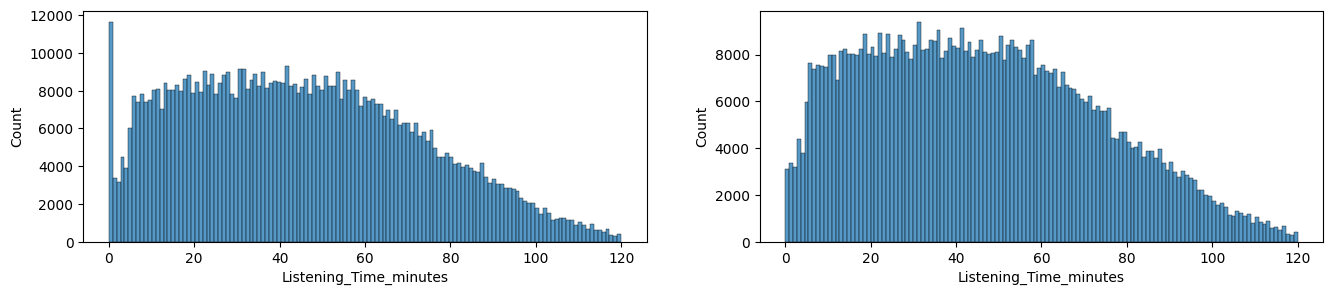

In [95]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train, x = target, ax = axes[0])
sns.histplot(df_train.loc[df_train[target] != 0], x = target, ax = axes[1])
plt.show()

In [307]:
df_train[target].describe()

count    750000.000000
mean         45.437412
std          27.138306
min           0.000000
25%          23.178350
50%          43.379459
75%          64.811577
max         119.970001
Name: Listening_Time_minutes, dtype: float64

In [323]:
(df_train[target] == 0).mean()

np.float64(0.011401333333333333)

- target은 0 이상 120이하 이며, 0 이하는 잘려 있어 빈도가 높습니다. 1.1% 가 0입니다.

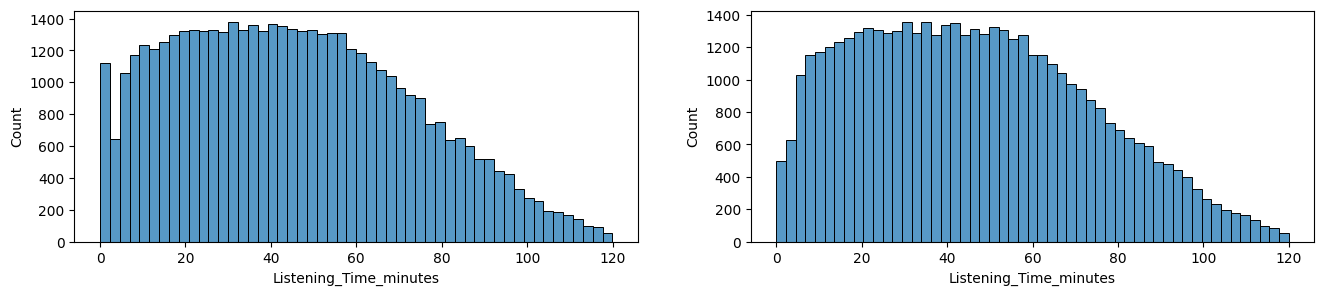

In [142]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_org, x = target, ax = axes[0])
sns.histplot(df_org.loc[df_org[target] != 0], x = target, ax = axes[1])
plt.show()

# 상관도 분석

In [99]:
from scipy.stats import kruskal

pd.Series([
    kruskal(*df_train.groupby(i)[target].agg(list)).pvalue
    for i in X_cat
], index = X_cat).sort_values()

Episode_Title         0.000000e+00
Podcast_Name          0.000000e+00
Episode_Sentiment    7.089348e-227
Publication_Time     1.662583e-107
Genre                 1.144837e-72
Publication_Day       3.139848e-70
dtype: float64

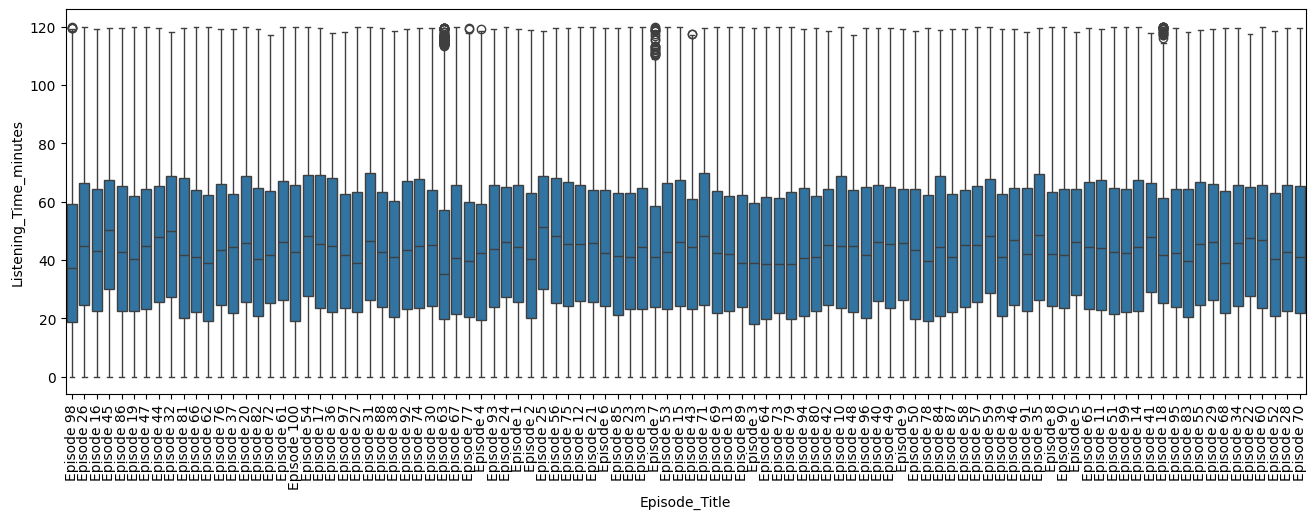

In [317]:
plt.figure(figsize = (16, 5))
sns.boxplot(df_train, x = 'Episode_Title', y = target)
plt.xticks(rotation = 90) 
plt.show()

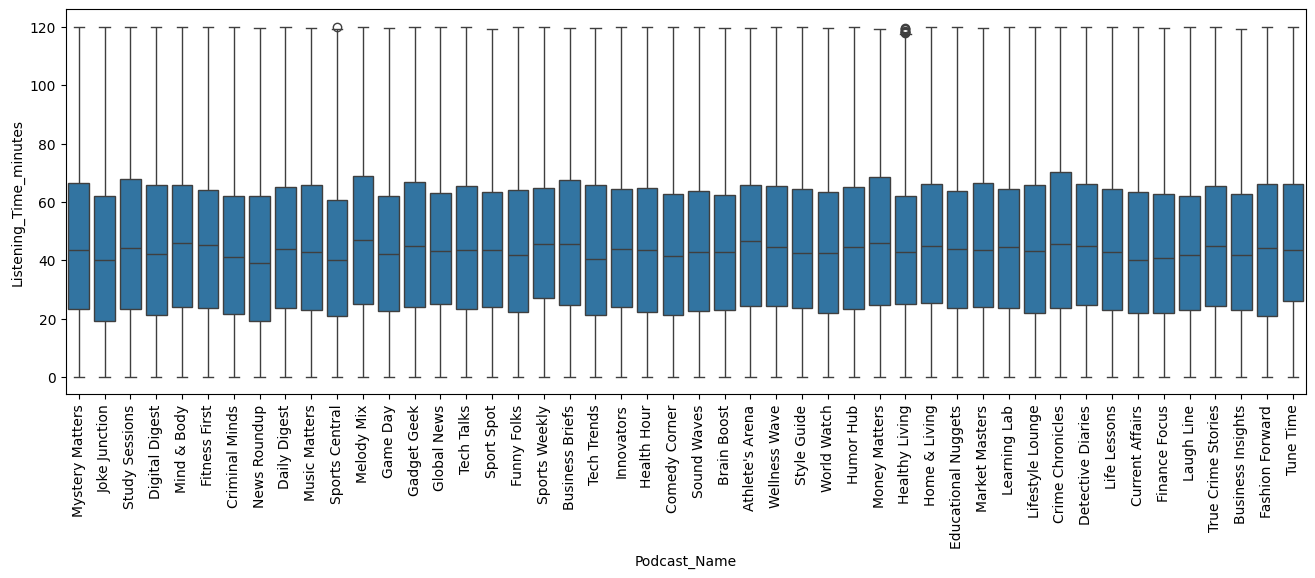

In [318]:
plt.figure(figsize = (16, 5))
sns.boxplot(df_train, x = 'Podcast_Name', y = target)
plt.xticks(rotation = 90) 
plt.show()

In [104]:
from scipy.stats import spearmanr
df_train[X_num].apply(
    lambda x: pd.Series(spearmanr(x.loc[x.notna()], df_train.loc[x.notna(), target]), index = ['coef', 'pvalue'])
).T.sort_values('pvalue')

,coef,pvalue
Episode_Length_minutes,0.931673,0.000000e+00
Host_Popularity_percentage,0.045404,0.000000e+00
Number_of_Ads,-0.115254,0.000000e+00
Guest_Popularity_percentage,-0.014498,1.895293e-29


- Episode_Length_minutes와 target과긔 강한상관도 가 있습니다.

# Episode_Length_minutes

In [108]:
(df_train[target] > df_train['Episode_Length_minutes']).mean(), (df_org[target] > df_org['Episode_Length_minutes']).mean()

(np.float64(0.003392), np.float64(0.0))

- target이 Episode_Length_minutes 보다 큰 경우는 거의 없습니다.

In [110]:
df_train['Episode_Length_minutes'].isna().mean()

np.float64(0.116124)

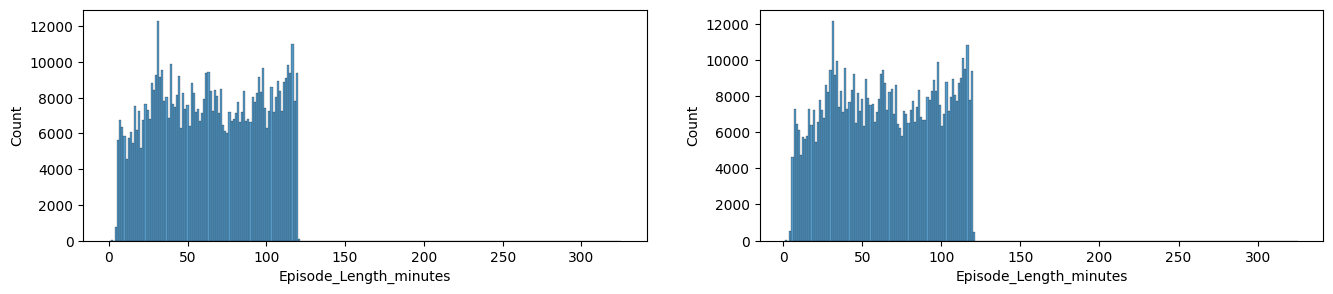

In [145]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train, x = 'Episode_Length_minutes', ax = axes[0])
sns.histplot(df_train.loc[df_train['Episode_Length_minutes'] != 0], x = 'Episode_Length_minutes', ax = axes[1])
plt.show()

In [146]:
df_train['Episode_Length_minutes'].describe()

count    662907.000000
mean         64.504738
std          32.969604
min           0.000000
25%          35.730000
50%          63.840000
75%          94.070000
max         325.239990
Name: Episode_Length_minutes, dtype: float64

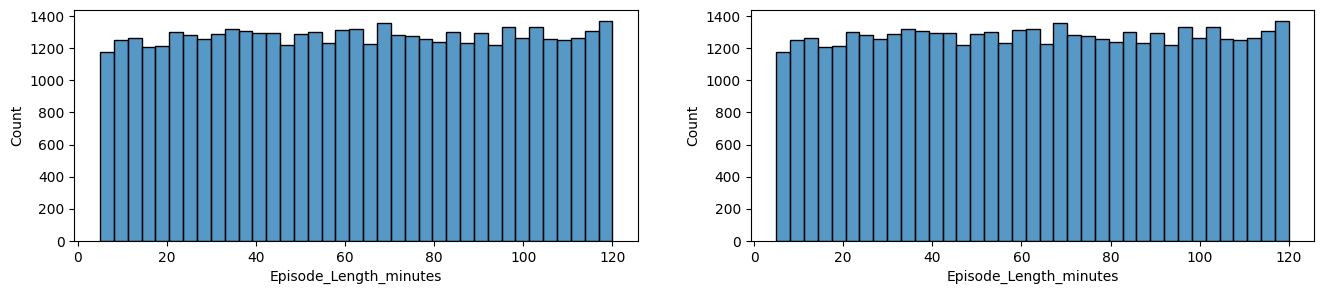

In [144]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_org, x = 'Episode_Length_minutes', ax = axes[0])
sns.histplot(df_org.loc[df_org['Episode_Length_minutes'] != 0], x = 'Episode_Length_minutes', ax = axes[1])
plt.show()

In [319]:
df_org['Episode_Length_minutes'].describe()

count    47254.000000
mean        62.853493
std         33.137428
min          5.000000
25%         34.299999
50%         62.869999
75%         91.550003
max        120.000000
Name: Episode_Length_minutes, dtype: float64

- Episode_Length_minutes 원본에는 5에서 120까지 범위를 지니는 반면, train에서는 0에서 325 노이즈가 보입니다.

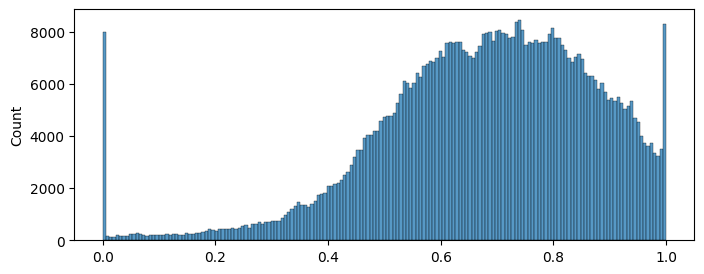

In [134]:
plt.figure(figsize = (8, 3))
sns.histplot(df_train.loc[df_train['Episode_Length_minutes'].notna()].pipe(lambda x: x[target] / x['Episode_Length_minutes']).clip(0, 1))
plt.show()

- 비율상 완전 시청과, 전혀 시청하지 않은 비율에 peek가 있습니다.

In [346]:
df_train.loc[df_train['Episode_Length_minutes'].notna()].pipe(lambda x: x[target] / x['Episode_Length_minutes']).clip(0, 1).value_counts(normalize=True).iloc[:10]

0.000000    0.011828
1.000000    0.006459
1.000000    0.000113
1.000000    0.000065
0.587523    0.000044
0.801871    0.000044
0.616323    0.000038
0.986733    0.000033
0.976807    0.000033
0.771417    0.000032
Name: proportion, dtype: float64

In [150]:
(df_train['Episode_Length_minutes'] <= 0).sum()

np.int64(1)

In [151]:
df_train.loc[df_train['Episode_Length_minutes'].notna() & (df_train['Episode_Length_minutes'] > 0)].pipe(
    lambda  x: x[target] / x['Episode_Length_minutes']
).describe()

count    662906.000000
mean          0.681033
std           0.263900
min           0.000000
25%           0.566296
50%           0.698387
75%           0.822374
max          94.177414
dtype: float64

- Listening_Time_minutes,	Episode_Length_minutes 둘의 비율상으로 이상여부에 해당하는 게 더 뚜렷이 보입니다.

In [156]:
df_train.loc[
    df_train[target] > df_train['Episode_Length_minutes'], [target, 'Episode_Length_minutes']
].assign(
    ratio = lambda x: x[target] / x['Episode_Length_minutes'].clip(lower = 1e-3)
).sort_values('ratio', ascending = False).iloc[:30]

,Listening_Time_minutes,Episode_Length_minutes,ratio
id,,,
150178,9.606840,0.000000,9606.839844
250219,116.779999,1.240000,94.177414
453791,116.769997,1.480000,78.898643
642283,100.360001,1.840000,54.543476
107984,62.252201,2.470000,25.203320
486115,62.107521,2.470000,25.144745
674029,62.107521,2.470000,25.144745
553429,62.107521,2.470000,25.144745
63965,113.331757,12.010000,9.436449


In [158]:
df_train.loc[
    df_train['Episode_Length_minutes'] == 2.470000
]

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
107984,Detective Diaries,Episode 52,2.47,True Crime,35.049999,Saturday,Night,75.680000,0.0,Neutral,62.252201
486115,Laugh Line,Episode 78,2.47,Comedy,39.299999,Monday,Afternoon,79.300003,0.0,Negative,62.107521
553429,Laugh Line,Episode 78,2.47,Comedy,79.660004,Monday,Afternoon,38.459999,0.0,Negative,62.107521
674029,Mind & Body,Episode 85,2.47,Health,79.660004,Monday,Afternoon,4.200000,0.0,Negative,62.107521


- 동일한 	Episode_Length_minutes에 해당하는 Listening_Time_minutes가 여럿 보입니다.

In [324]:
df_train[target].value_counts()

Listening_Time_minutes
0.000000     8551
5.820000      124
8.750000      108
10.550000     108
6.160000       98
             ... 
45.352390       3
48.973991       3
21.757370       2
50.747360       2
69.189629       2
Name: count, Length: 42807, dtype: int64

In [325]:
df_train.groupby('Listening_Time_minutes')['Episode_Length_minutes'].agg(
    ['mean', 'std', 'count']
).sort_values('std').iloc[:15]

,mean,std,count
Listening_Time_minutes,,,
32.274410,32.270000,0.000000,3
58.578930,76.339996,0.000000,3
103.788933,114.370003,0.000000,13
21.757370,40.090000,0.000000,2
11.863840,26.690001,0.000000,9
15.028780,15.620000,0.000000,5
109.421883,116.209999,0.000000,10
39.190010,49.950001,0.000000,6
108.056503,110.930000,0.000000,3


In [326]:
df_train.groupby('Listening_Time_minutes')['Episode_Length_minutes'].agg(['mean', 'std', 'count']).dropna().sort_values('std').iloc[-15:]

,mean,std,count
Listening_Time_minutes,,,
57.823460,79.893333,30.564819,9
52.440269,87.791252,30.628937,8
37.127041,72.099091,32.455738,11
54.645920,56.610912,32.989033,11
27.218910,54.491249,33.389942,8
24.139851,63.568462,33.576218,13
113.331757,104.367645,34.773888,17
64.854179,67.931740,35.015186,23
62.107521,73.934120,35.487297,17


In [183]:
df_train.groupby('Episode_Length_minutes')['Listening_Time_minutes'].agg(
    ['mean', 'std', 'count']
).sort_values(['std', 'count'], ascending = [True, False]).iloc[:15]

,mean,std,count
Episode_Length_minutes,,,
54.286304,54.286312,0.0,11
72.908997,72.909271,0.0,9
8.346000,8.346160,0.0,8
60.278461,60.278461,0.0,8
63.115452,63.115452,0.0,8
107.001999,107.000000,0.0,8
5.438000,5.438240,0.0,7
6.008562,6.000000,0.0,7
7.464750,7.464750,0.0,7


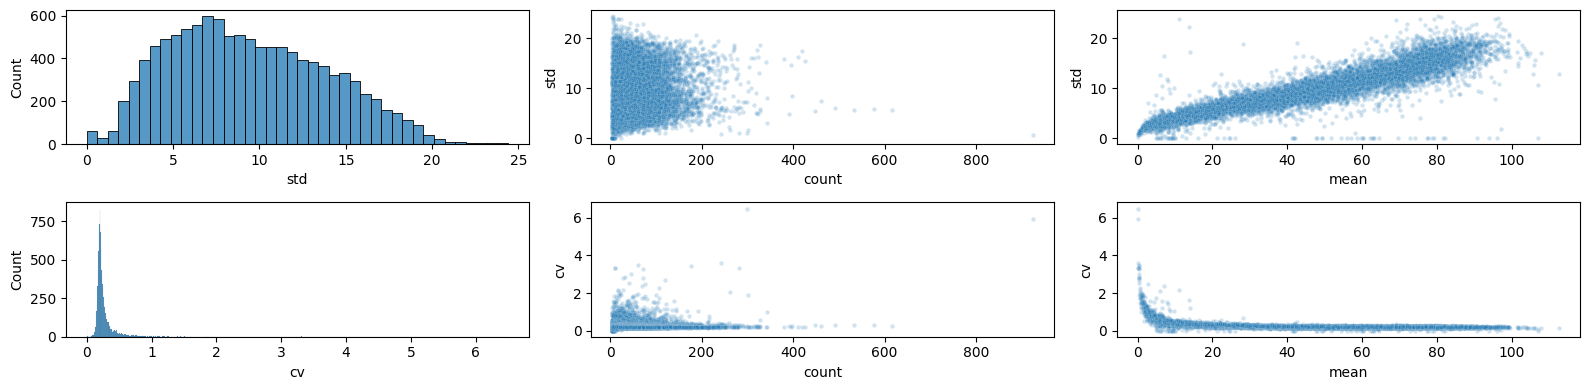

In [338]:
fig, axes = plt.subplots(2, 3, figsize=(16, 4))
axes = axes.flatten()
df_tmp = df_train.groupby('Episode_Length_minutes').filter(lambda x: len(x) >= 5).groupby('Episode_Length_minutes')['Listening_Time_minutes'].agg(
    ['mean', 'std', 'count']
).assign(
    cv = lambda x: x['std'] / x['mean']
)
sns.histplot(
    df_tmp, x = 'std', ax = axes[0]
)
sns.scatterplot(
    df_tmp, x = 'count',  y = 'std', s = 10, alpha = 0.2, ax = axes[1]
)
sns.scatterplot(
    df_tmp, x = 'mean', y = 'std', s = 10, alpha = 0.2, ax = axes[2]
)

sns.histplot(
    df_tmp, x = 'cv', ax = axes[3]
)
sns.scatterplot(
    df_tmp, x = 'count',  y = 'cv', s = 10, alpha = 0.2, ax = axes[4]
)
sns.scatterplot(
    df_tmp, x = 'mean', y = 'cv', s = 10, alpha = 0.2, ax = axes[5]
)
plt.tight_layout()
plt.show()

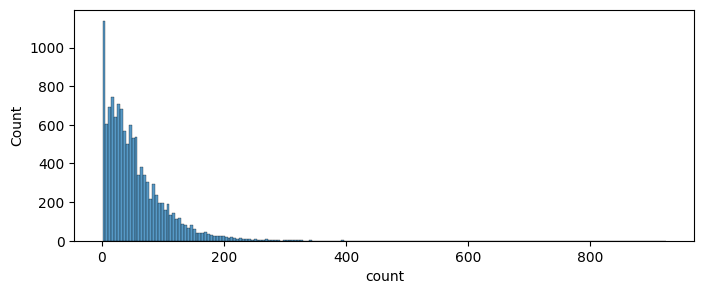

In [339]:
plt.figure(figsize = (8, 3))
sns.histplot(
    df_train['Episode_Length_minutes'].value_counts()
)
plt.show()

- Episode_Length_minutes 별로 그룹 핑해서 보았을 때 표준편차의 분포가 우측으로 치우침이 보입니다. 변동계수가 Episode_Length_minutes가 작을 수록 강한 변동성이 보입니다. 

- Episode_Length_minutes 가 연속형 변수로써도 의미가 있지만, Episode_Length_minutes 범주형 변수로서도 의미가 있어 보입니다.

In [200]:
# Test에 Train에 등장하지 않은 Episode_Length_minutes의 비율
df_test['Episode_Length_minutes'].value_counts().pipe(
    lambda x: x.index.isin(set(df_test['Episode_Length_minutes'].dropna()) - set(df_train['Episode_Length_minutes'].dropna()))
).mean()

np.float64(0.013683304647160069)

Test에 Train에 등장하지 않은 Episode_Length_minutes의 비율을 0.01368% 입니다.

In [362]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, root_mean_squared_error
df_train_1 = df_train.loc[df_train['Episode_Length_minutes'].notna()]
df_train_2 = df_train.loc[df_train['Episode_Length_minutes'].isna()]
kf = KFold(5, random_state = 123, shuffle = True)

In [363]:
df_train_1[target].agg(['mean', 'std']), df_train_2[target].agg(['mean', 'std'])

(mean    45.737988
 std     27.269079
 Name: Listening_Time_minutes, dtype: float32,
 mean    43.149540
 std     26.008022
 Name: Listening_Time_minutes, dtype: float32)

In [364]:
from scipy.stats import mannwhitneyu
mannwhitneyu(
    df_train_1[target], df_train_2[target]
)

MannwhitneyuResult(statistic=np.float64(30389405013.0), pvalue=np.float64(1.1827580948468853e-141))

결측 여부에 따라 target의 차이있습니다.

In [365]:
df_train[X_cat].apply(
    lambda x: pd.Series(
        chi2_contingency(
            pd.crosstab(index = df_train['Episode_Length_minutes'].isna(), columns = x)
        ).pvalue
    )
)

,Episode_Sentiment,Episode_Title,Genre,Podcast_Name,Publication_Day,Publication_Time
0,5.602483e-11,3.935818e-70,1.090954e-16,8.620505e-32,4.150232e-13,5.288669e-09


- 결측 여부에 따라 Episode_Title과 Podcast_Name의 분포의 차이도 있습니다.

In [366]:
reg_list, prd_list, metric_list = list(), list(), list()
kf = KFold(5, random_state = 123, shuffle = True)
for train_idx, valid_idx in kf.split(df_train_1[['Episode_Length_minutes']], df_train_1[target]):
    df_cv_train, df_valid = df_train_1.iloc[train_idx], df_train_1.iloc[valid_idx]
    reg_lr = LinearRegression(fit_intercept = False).fit(df_cv_train[['Episode_Length_minutes']], df_cv_train[target])
    reg_list.append(reg_lr)
    prd_list.append(pd.Series(
        reg_lr.predict(df_valid[['Episode_Length_minutes']]), index = df_valid.index, name = 'prd'
    ))
    metric_list.append(
        (r2_score(df_valid[target], prd_list[-1]), root_mean_squared_error(df_valid[target], prd_list[-1]))
    )
metric_list

[(0.8376334309577942, np.float32(10.995278)),
 (0.8377830982208252, np.float32(10.981325)),
 (0.8382234573364258, np.float32(10.975433)),
 (0.8372305035591125, np.float32(10.991248)),
 (0.8372507095336914, np.float32(10.998068))]

In [367]:
reg_list, prd_list, metric_list = list(), list(), list()
for train_idx, valid_idx in kf.split(df_train_1[['Episode_Length_minutes']], df_train_1[target]):
    df_cv_train, df_valid = df_train_1.iloc[train_idx], df_train_1.iloc[valid_idx]
    df_cv_train = df_cv_train.loc[(df_cv_train['Episode_Length_minutes'] > df_cv_train[target]) & (df_cv_train[target] > 0)]
    reg_lr = LinearRegression(fit_intercept = False).fit(df_cv_train[['Episode_Length_minutes']], df_cv_train[target])
    reg_list.append(reg_lr)
    prd_list.append(pd.Series(
        reg_lr.predict(df_valid[['Episode_Length_minutes']]), index = df_valid.index, name = 'prd'
    ))
    metric_list.append(
        (r2_score(df_valid[target], prd_list[-1]), root_mean_squared_error(df_valid[target], prd_list[-1]))
    )
metric_list

[(0.8376257419586182, np.float32(10.995538)),
 (0.8377805948257446, np.float32(10.981411)),
 (0.8382096290588379, np.float32(10.975904)),
 (0.8372260928153992, np.float32(10.991397)),
 (0.8372499346733093, np.float32(10.998095))]

In [368]:
r = np.mean([i.coef_ for i in reg_list])
r

np.float32(0.71834433)

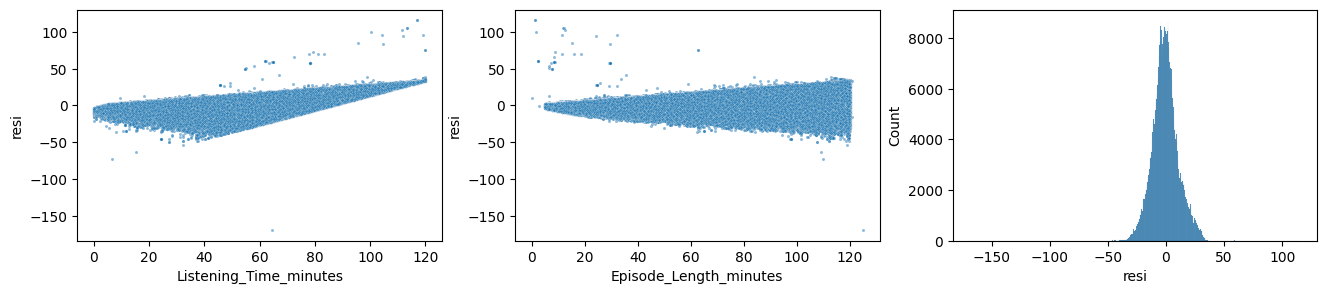

In [369]:
fig, axes = plt.subplots(1, 3, figsize = (16, 3))
df_resi = df_train_1[['Episode_Length_minutes', target]].assign(
    Episode_Length_minutes = lambda x: x['Episode_Length_minutes'].clip(0, 125),
    resi = lambda x: x[target] - pd.concat(prd_list).sort_index()
)
sns.scatterplot(df_resi, x = target, y = 'resi', ax = axes[0], s = 5, alpha = 0.5)
sns.scatterplot(df_resi, x = 'Episode_Length_minutes', y = 'resi', ax = axes[1], s = 5, alpha = 0.5)
sns.histplot(df_resi, x = 'resi', ax = axes[2])
plt.show()

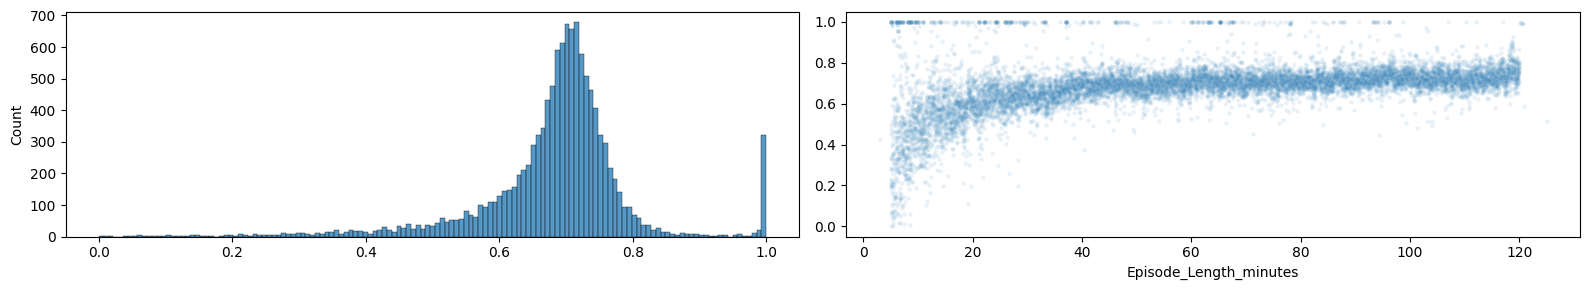

In [370]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
s_rate = df_train_1.loc[
    (df_train_1['Episode_Length_minutes'] > df_train_1[target]) & (df_train_1['Episode_Length_minutes'] > 0)
].groupby(df_train_1['Episode_Length_minutes'].clip(0, 125))[target].mean().pipe(
    lambda x: x / x.index
)
sns.histplot(s_rate, ax = axes[0])
sns.scatterplot(s_rate, ax = axes[1], s= 10, alpha = 0.1)
plt.tight_layout()
plt.show()

- Episode_Length_minutes가 작을 수록 Episode_Length_minutes와 타겟같의 비율은 작습니다.

- Episode_Length_minutes의 sqrt를 넣어 봅니다.

In [371]:
reg_list, prd_list, metric_list = list(), list(), list()
for train_idx, valid_idx in kf.split(df_train_1[['Episode_Length_minutes']], df_train_1[target]):
    df_cv_train, df_valid = df_train_1.iloc[train_idx], df_train_1.iloc[valid_idx]
    df_cv_train = df_cv_train.loc[(df_cv_train['Episode_Length_minutes'] > df_cv_train[target]) & (df_cv_train[target] > 0)]
    reg_lr = LinearRegression(fit_intercept = False).fit(
        df_cv_train[['Episode_Length_minutes']].assign(
            elm_sqrt = lambda x: x['Episode_Length_minutes'] ** 0.5,
        ), df_cv_train[target]
    )
    reg_list.append(reg_lr)
    prd_list.append(pd.Series(
        reg_lr.predict(
            df_valid[['Episode_Length_minutes']].assign(
                elm_sqrt = lambda x: x['Episode_Length_minutes'] ** 0.5
            )
        ), index = df_valid.index, name = 'prd'
    ))
    metric_list.append(
        (r2_score(df_valid[target], prd_list[-1]), root_mean_squared_error(df_valid[target], prd_list[-1]))
    )
metric_list

[(0.8404818177223206, np.float32(10.898406)),
 (0.8405865430831909, np.float32(10.886022)),
 (0.8411245942115784, np.float32(10.876577)),
 (0.8400450348854065, np.float32(10.895805)),
 (0.8398939371109009, np.float32(10.908393))]

In [372]:
reg_list[0].coef_

array([ 0.8177081, -0.9145644], dtype=float32)

- 'Episode_Length_minutes' sqrt 를 적용했을 때 r2, mse가 줄어 듭니다.

In [373]:
reg_list, prd_list, metric_list = list(), list(), list()
for train_idx, valid_idx in kf.split(df_train_1[['Episode_Length_minutes']], df_train_1[target]):
    df_cv_train, df_valid = df_train_1.iloc[train_idx], df_train_1.iloc[valid_idx]
    df_cv_train = df_cv_train.loc[(df_cv_train['Episode_Length_minutes'] > df_cv_train[target]) & (df_cv_train[target] > 0)]
    reg_lr = LinearRegression(fit_intercept = False).fit(
        df_cv_train[['Episode_Length_minutes']].assign(
            elm_sqrt = lambda x: x['Episode_Length_minutes'] ** 0.5,
        ), df_cv_train[target]
    )
    reg_list.append(reg_lr)
    prd_list.append(pd.Series(
        reg_lr.predict(
            df_valid[['Episode_Length_minutes']].assign(
                elm_sqrt = lambda x: x['Episode_Length_minutes'] ** 0.5
            )
        ), index = df_valid.index, name = 'prd'
    ))
    metric_list.append(
        (r2_score(df_valid[target], prd_list[-1]), root_mean_squared_error(df_valid[target], prd_list[-1]))
    )
metric_list

[(0.8404818177223206, np.float32(10.898406)),
 (0.8405865430831909, np.float32(10.886022)),
 (0.8411245942115784, np.float32(10.876577)),
 (0.8400450348854065, np.float32(10.895805)),
 (0.8398939371109009, np.float32(10.908393))]

In [374]:
df_resi = df_train_1.assign(
    resi = lambda x: x[target] - pd.concat(prd_list).sort_index()
)
df_resi

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,resi
id,,,,,,,,,,,,
1,Joke Junction,Episode 26,119.800003,Comedy,66.949997,Saturday,Afternoon,75.949997,2.0,Negative,88.012413,0.081932
2,Study Sessions,Episode 16,73.900002,Education,69.970001,Tuesday,Evening,8.970000,0.0,Negative,44.925308,-7.648514
3,Digital Digest,Episode 45,67.169998,Technology,57.220001,Monday,Morning,78.699997,2.0,Positive,46.278240,-1.148369
4,Mind & Body,Episode 86,110.510002,Health,80.070000,Monday,Afternoon,58.680000,3.0,Neutral,75.610313,-5.149445
5,Fitness First,Episode 19,26.540001,Health,48.959999,Saturday,Afternoon,NaN,3.0,Positive,22.770470,5.797979
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,Episode 25,75.660004,Education,69.360001,Saturday,Morning,NaN,0.0,Negative,56.870579,2.957912
749996,Business Briefs,Episode 21,75.750000,Business,35.209999,Saturday,Night,NaN,2.0,Neutral,45.462421,-8.513184
749997,Lifestyle Lounge,Episode 51,30.980000,Lifestyle,78.580002,Thursday,Morning,84.889999,0.0,Negative,15.260000,-4.982161


In [375]:
from scipy.stats import kruskal
pd.Series([
    kruskal(*df_train_1.groupby(i)['Episode_Length_minutes'].agg(list)).pvalue
    for i in X_cat
], index = X_cat).sort_values()

Episode_Title         0.000000e+00
Podcast_Name         9.353028e-311
Episode_Sentiment    6.673992e-127
Publication_Time      1.518029e-74
Publication_Day       5.022372e-64
Genre                 6.316681e-62
dtype: float64

In [378]:
df_train_1[X_num].pipe(
    lambda x: x[[i for i in X_num if i != 'Episode_Length_minutes']].apply(
        lambda y: pd.Series(
            spearmanr(y.loc[y.notna()], x.loc[y.notna(), 'Episode_Length_minutes']), index =['coef', 'pvalue']
        )
    )
)

,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
coef,2.424576e-02,-9.160845e-03,-0.058204
pvalue,9.115160e-87,1.743735e-11,0.000000


In [399]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits = 1, train_size = 0.75, random_state = 123)

X_val = X_num + X_cat
X_sel = ['Episode_Length_minutes']
scores_step = [-np.inf]

while len(X_sel) < len(X_val):
    X_step = [i for i in X_val if i not in X_sel]
    scores = list()
    for i in X_step:
        X_lr = X_sel + [i]
        X_num_lr = [j for j in X_lr if j in X_num]
        X_cat_lr = [j for j in X_lr if j in X_cat]
        reg_lr = make_pipeline(
            ColumnTransformer([
                ('sqrt', make_pipeline(FunctionTransformer(lambda x: x ** 0.5), StandardScaler()), ['Episode_Length_minutes']),
                ('std', make_pipeline(SimpleImputer(), StandardScaler()), X_num_lr),
                ('ohe', OneHotEncoder(drop = 'first'), X_cat_lr)
            ]), LinearRegression()
        )
        scores.append(
            cross_val_score(
                reg_lr, df_train_1[X_cat + X_num], df_train_1[target], cv = ss, scoring = 'neg_root_mean_squared_error'
            ).mean()
        )
    
    if scores_step[-1] > np.max(scores):
        break
    scores_step.append(np.max(scores))
    X_sel.append(
        X_step[np.argmax(scores)]
    )
    print(X_sel[-1], scores_step[-1])

Number_of_Ads -10.742903709411621
Host_Popularity_percentage -10.719416618347168
Podcast_Name -10.7086579720447
Episode_Sentiment -10.698344232545033
Episode_Title -10.693799101416769
Publication_Day -10.692747152876082
Guest_Popularity_percentage -10.692051503734907
Publication_Time -10.691523040784219


In [402]:
X_sel, [i for i in X_val if i not in X_sel], np.max(scores)

(['Episode_Length_minutes',
  'Number_of_Ads',
  'Host_Popularity_percentage',
  'Podcast_Name',
  'Episode_Sentiment',
  'Episode_Title',
  'Publication_Day',
  'Guest_Popularity_percentage',
  'Publication_Time'],
 ['Genre'],
 np.float64(-10.69169036772223))

In [293]:
import lightgbm as lgb
from sklearn.model_selection import cross_validate

X_lgb_num = ['Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
X_lgb = X_cat + X_lgb_num
cross_validate(
    lgb.LGBMRegressor(verbose=-1, num_leaves = 15, n_estimators = 200, learning_rate = 0.07), 
    df_train_1[X_lgb], df_train_1['Episode_Length_minutes'], scoring = 'r2', cv = kf, params = {'categorical_feature': X_cat}, return_train_score = True
)

{'fit_time': array([0.8503089 , 0.83857536, 0.85611176, 0.88836956, 1.60209775]),
 'score_time': array([0.19065499, 0.18762946, 0.18983555, 0.19206238, 0.18445683]),
 'test_score': array([0.02478846, 0.02683115, 0.02555192, 0.02632938, 0.02723485]),
 'train_score': array([0.04275233, 0.04227664, 0.04285181, 0.04196608, 0.04293988])}

In [80]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import chi2_contingency
idx, col = np.tril_indices(len(X_cat), -1)
pd.DataFrame({
    'val1': np.array(X_cat)[idx],
    'val2': np.array(X_cat)[col],
    'pvalue': pdist(
        df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns =v)).pvalue
    )
}).sort_values('pvalue')

,val1,val2,pvalue
6,Publication_Day,Episode_Sentiment,0.000000e+00
5,Podcast_Name,Genre,0.000000e+00
9,Publication_Day,Podcast_Name,0.000000e+00
12,Publication_Time,Genre,1.658142e-240
7,Publication_Day,Episode_Title,2.311971e-193
13,Publication_Time,Podcast_Name,2.154964e-163
10,Publication_Time,Episode_Sentiment,1.190066e-148
2,Genre,Episode_Title,7.428701e-129
0,Episode_Title,Episode_Sentiment,7.293837e-127
8,Publication_Day,Genre,2.613911e-82


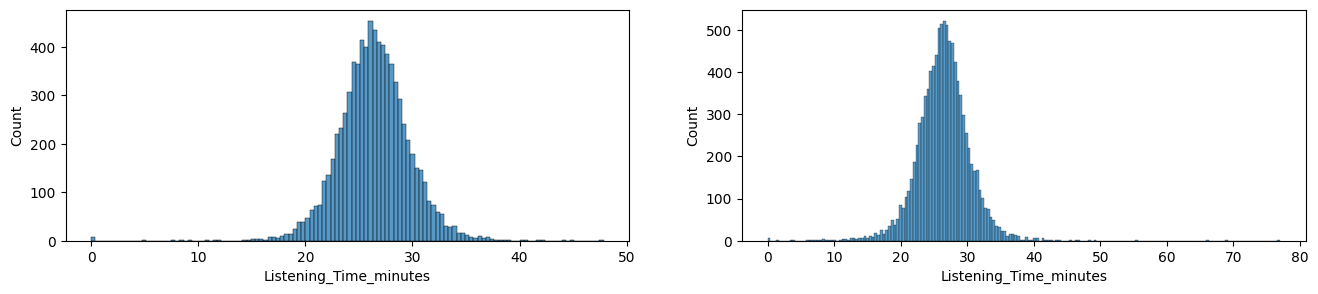

In [379]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(
    df_train.groupby('Host_Popularity_percentage')['Listening_Time_minutes'].agg('std'), ax = axes[0]
)
sns.histplot(
    df_train.groupby('Guest_Popularity_percentage')['Listening_Time_minutes'].agg('std'), ax = axes[1]
)
plt.show()